In [39]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from db.db_conn import session_scope
from db.models import FactFunding, DimensionOrganization, DimensionLocation, DimensionIndustry, InvestorMapping, DimensionInvestor, IndustryMapping, DimensionIndustryCluster

## Get Data

In [40]:
# Create the join query with all columns
with session_scope() as session:
    query = (
        session.query(FactFunding, DimensionOrganization, DimensionLocation, DimensionIndustry, DimensionInvestor)
        .join(DimensionOrganization, FactFunding.organization_id == DimensionOrganization.organization_id)
        .join(DimensionLocation, DimensionOrganization.location_id == DimensionLocation.location_id, isouter=True)
        .join(IndustryMapping, DimensionOrganization.organization_id == IndustryMapping.organization_id, isouter=True)
        .join(DimensionIndustry, IndustryMapping.industry_id == DimensionIndustry.industry_id, isouter=True)
        .join(InvestorMapping, FactFunding.transaction_id == InvestorMapping.transaction_id, isouter=True)
        .join(DimensionInvestor, InvestorMapping.investor_id == DimensionInvestor.investor_id, isouter=True)
    )

    # Execute the query and load results into a DataFrame
    big_df = pd.read_sql(query.statement, session.bind)

# Display information about the merged DataFrame
print(big_df.columns)

Index(['transaction_id', 'organization_id', 'transaction_name',
       'transaction_name_url', 'money_raised', 'money_raised_currency',
       'money_raised_usd', 'funding_type', 'announced_date',
       'pre_money_valuation', 'pre_money_valuation_currency',
       'pre_money_valuation_usd', 'funding_stage', 'number_of_funding_rounds',
       'total_funding_amount', 'total_funding_currency',
       'total_funding_amount_usd', 'equity_only', 'funding_status',
       'number_of_investors', 'funding_amount_cluster', 'money_raised_cluster',
       'transaction_cluster', 'organization_id_1', 'organization_name',
       'organization_website', 'organization_name_url',
       'organization_description', 'location_id', 'industry_cluster_id',
       'location_id_1', 'city', 'country_id', 'longitude', 'latitude',
       'industry_id', 'industry', 'investor_id', 'investor'],
      dtype='object')


## Create cluster based on Total Funding Amount in USD

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans

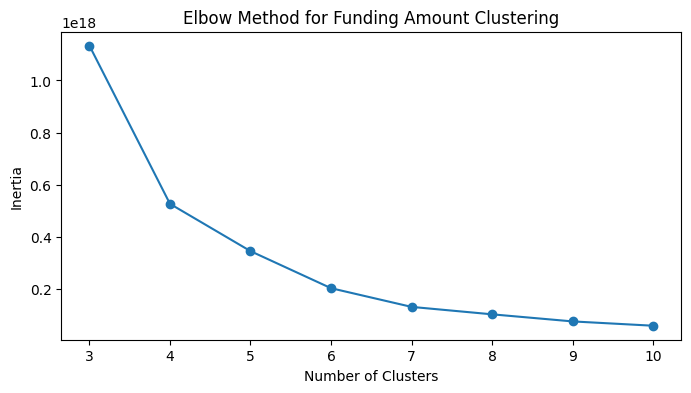

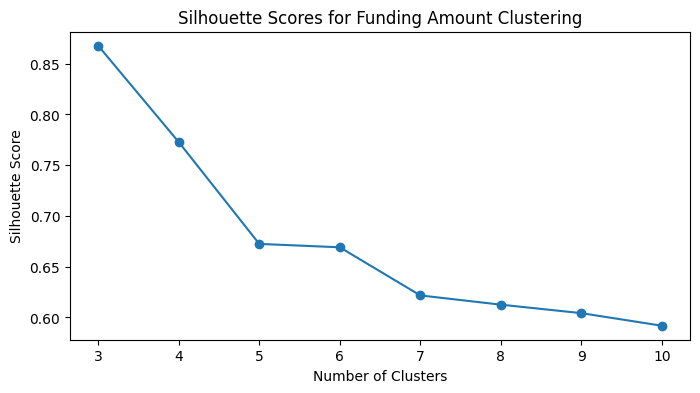

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_5116/943489124.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na_fa['funding_amount_cluster'] = kmeans.fit_predict(funding_amount)


Unique Clusters: [0 1 2]


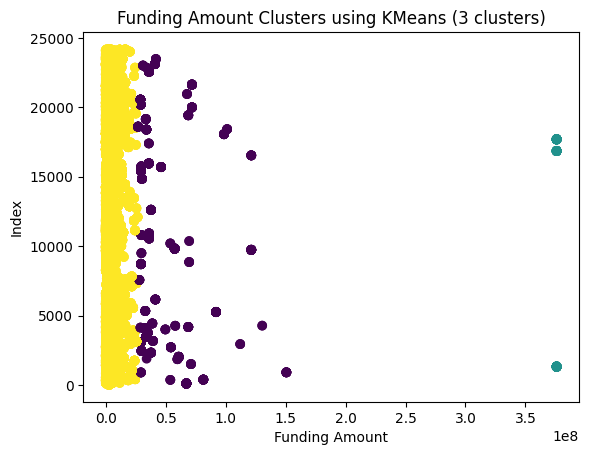

In [41]:
# Create a cleared copy of the dataframe
df_na_fa = big_df.dropna(subset=['total_funding_amount_usd'])

funding_amount = df_na_fa[['total_funding_amount_usd']]

# Finding the best number of clusters using the Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(3, 11)  # Try different values for n_clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(funding_amount)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(funding_amount, cluster_labels))

# Plotting the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Funding Amount Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Funding Amount Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Fit KMeans with the optimal number of clusters (based on Elbow or Silhouette)
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]  # or choose based on elbow
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_na_fa['funding_amount_cluster'] = kmeans.fit_predict(funding_amount)

# Display unique clusters
print("Unique Clusters:", np.unique(df_na_fa['funding_amount_cluster']))

# Plotting the clusters
plt.scatter(funding_amount, range(len(funding_amount)), c=df_na_fa['funding_amount_cluster'], cmap='viridis')
plt.xlabel('Funding Amount')
plt.ylabel('Index')
plt.title(f'Funding Amount Clusters using KMeans ({optimal_clusters} clusters)')
plt.show()

# Left join the 'funding_amount_cluster' column with the original big_df
big_df = big_df.merge(df_na_fa[['funding_amount_cluster']], left_index=True, right_index=True, how='left')


## Create cluster based on Money Raised in USD

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans

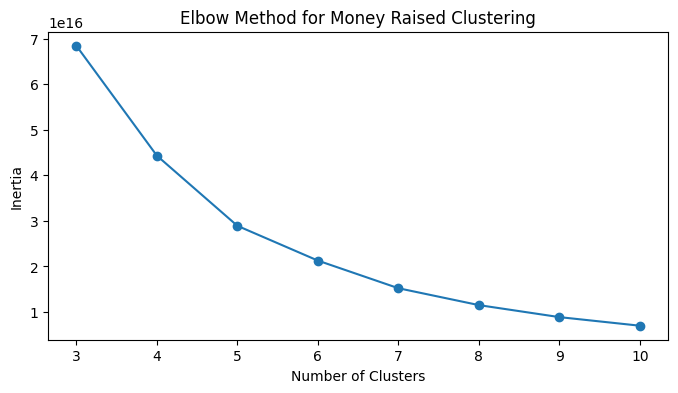

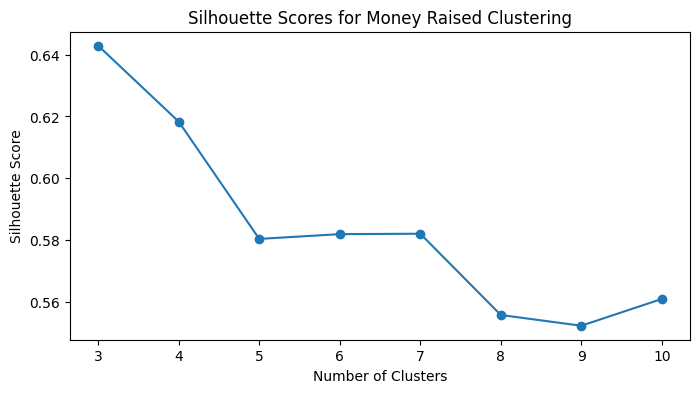

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_5116/3311514427.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na_mr['money_raised_cluster'] = kmeans.fit_predict(money_raised)


Unique Clusters: [0 1 2]


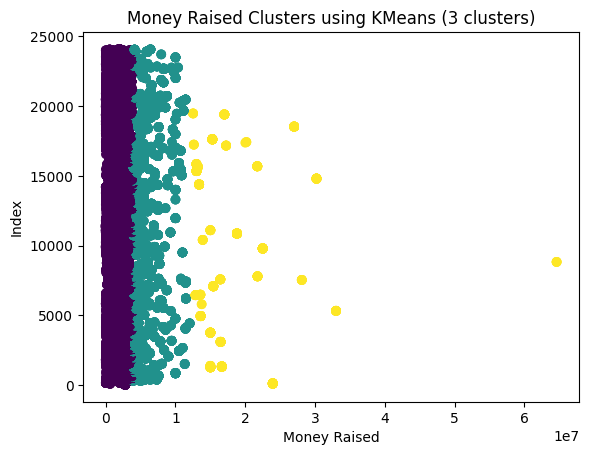

In [42]:
# Create a cleared copy of the dataframe
df_na_mr = big_df.dropna(subset=['money_raised_usd'])

money_raised = df_na_mr[['money_raised_usd']]

# Finding the best number of clusters using the Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(3, 11)  # Try different values for n_clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(money_raised)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(money_raised, cluster_labels))

# Plotting the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Money Raised Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Money Raised Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Fit KMeans with the optimal number of clusters (based on Elbow or Silhouette)
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]  # or choose based on elbow
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_na_mr['money_raised_cluster'] = kmeans.fit_predict(money_raised)

# Display unique clusters
print("Unique Clusters:", np.unique(df_na_mr['money_raised_cluster']))

# Plotting the clusters
plt.scatter(money_raised, range(len(money_raised)), c=df_na_mr['money_raised_cluster'], cmap='viridis')
plt.xlabel('Money Raised')
plt.ylabel('Index')
plt.title(f'Money Raised Clusters using KMeans ({optimal_clusters} clusters)')
plt.show()

# Left join the 'money_raised_cluster' column with the original big_df
big_df = big_df.merge(df_na_mr[['money_raised_cluster']], left_index=True, right_index=True, how='left')


## Cluster Investors based on their strategy

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans

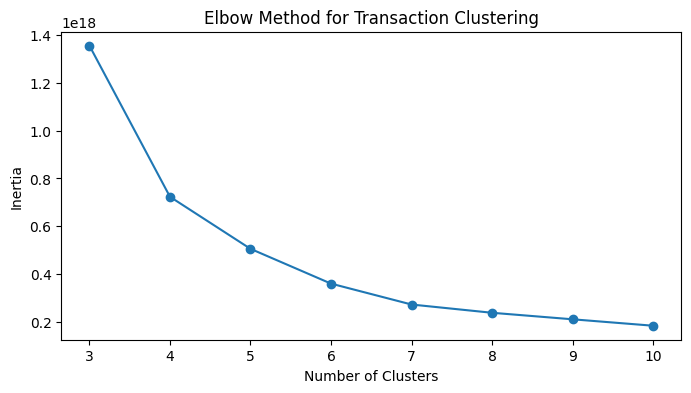

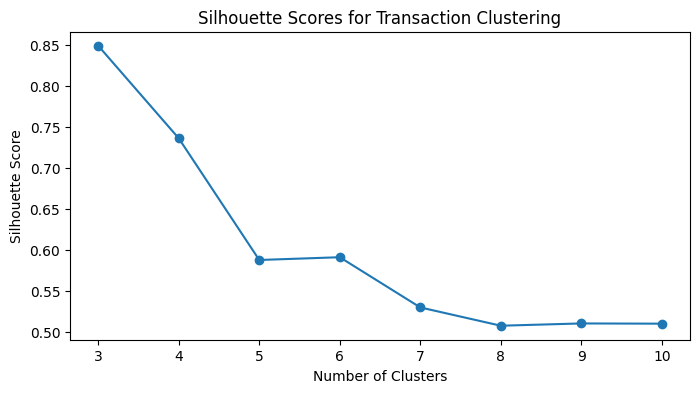

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_5116/3205363181.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mv['transaction_cluster'] = kmeans.fit_predict(features)


Unique Transaction Clusters: [0 1 2]


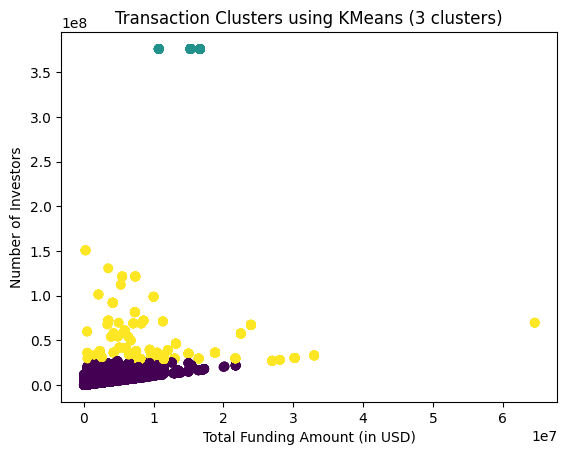

In [43]:
# Drop rows with NA in relevant columns
df_mv = big_df.dropna(subset=['money_raised_usd', 'funding_type', 'funding_stage', 'total_funding_amount_usd'])

# Clustering Total Funding Amount using KMeans
features = df_mv[['money_raised_usd', 'funding_type', 'funding_stage', 'total_funding_amount_usd']]

# Encode categorical variables like 'Funding Type' and 'Funding Stage'
features = pd.get_dummies(features, columns=['funding_type', 'funding_stage'], drop_first=True)

# Finding the best number of clusters using the Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(3, 11)  # Try different values for n_clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features, cluster_labels))

# Plotting the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Transaction Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Transaction Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Fit KMeans with the optimal number of clusters (based on Elbow or Silhouette)
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]  # or choose based on elbow
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_mv['transaction_cluster'] = kmeans.fit_predict(features)

# Display unique clusters
print("Unique Transaction Clusters:", np.unique(df_mv['transaction_cluster']))

# Plotting the clusters (using the first two features for visualization)
plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=df_mv['transaction_cluster'], cmap='viridis')
plt.xlabel('Total Funding Amount (in USD)')
plt.ylabel('Number of Investors')
plt.title(f'Transaction Clusters using KMeans ({optimal_clusters} clusters)')
plt.show()

# Left join the 'transaction_cluster' column with the original big_df
big_df = big_df.merge(df_mv[['transaction_cluster']], left_index=True, right_index=True, how='left')


In [44]:
# Generate descriptive names for each cluster based on centroid values
cluster_centroids = kmeans.cluster_centers_
cluster_names = []
feature_means = features.mean(axis=0)
feature_std = features.std(axis=0)  # Calculate standard deviation for determining medium values
threshold_high = 0.7  # Threshold for significant high difference
threshold_low = 0.1  # Threshold for significant low difference

for i, centroid in enumerate(cluster_centroids):
    description = []
    for j, value in enumerate(centroid):
        if value > feature_means[j] + threshold_high * feature_std[j]:
            description.append(f"High {features.columns[j]}")
        elif value < feature_means[j] - threshold_low * feature_std[j]:
            description.append(f"Low {features.columns[j]}")
        else:
            description.append(f"Medium {features.columns[j]}")
    cluster_name = f"Cluster {i}: {', '.join(description) if description else 'No significant difference'}"
    cluster_names.append(cluster_name)
    print(cluster_name)

Cluster 0: Low money_raised_usd, Low total_funding_amount_usd, Medium funding_type_Seed
Cluster 1: High money_raised_usd, High total_funding_amount_usd, High funding_type_Seed
Cluster 2: High money_raised_usd, High total_funding_amount_usd, Medium funding_type_Seed


/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_5116/286320713.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if value > feature_means[j] + threshold_high * feature_std[j]:
/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_5116/286320713.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif value < feature_means[j] - threshold_low * feature_std[j]:


## Create Labels for Company Descriptions
Further it is tried to create a more unified label for the companies. Currently the description as well as the industry data field contain a variety of different labels. 

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# Combine 'Organization Industries' and 'Organization Description' fields
big_df['combined_text'] = big_df['industry'].fillna('') + ' ' + big_df['organization_description'].fillna('')

# Drop rows with empty combined text
df_combined = big_df.dropna(subset=['industry'])

# Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_combined['industry'])

# Apply KMeans clustering
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_combined['company_cluster'] = kmeans.fit_predict(tfidf_matrix)

# Print unique clusters
print("Unique Company Clusters:", df_combined['company_cluster'].unique())

# Apply LDA on each cluster to generate topic-based labels
words = tfidf_vectorizer.get_feature_names_out()
for cluster_id in range(n_clusters):
    # Filter companies in the current cluster
    cluster_data = df_combined[df_combined['company_cluster'] == cluster_id]
    cluster_matrix = tfidf_vectorizer.transform(cluster_data['industry'])
    
    # Apply LDA to the cluster data
    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(cluster_matrix)
    
    # Get the top words for the topic
    topic_words = [words[i] for i in lda.components_[0].argsort()[-5:]]
    print(f"Cluster {cluster_id} Label: {' '.join(topic_words)}")

# Merge cluster labels back to the original DataFrame
big_df = big_df.merge(df_combined[['company_cluster']], left_index=True, right_index=True, how='left')


/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Unique Company Clusters: [2 3 1 0 6 4 5]
Cluster 0 Label: cloud professional information financial services
Cluster 1 Label: employment enablement engine young fintech
Cluster 2 Label: employment enablement engineering enterprise software
Cluster 3 Label: care energy health information technology
Cluster 4 Label: enablement electronic ai intelligence artificial
Cluster 5 Label: employee employment electrical young saas
Cluster 6 Label: young desktop web mobile apps


## Company Embeddings based on labels
- These embeddings represent the semantic relationships between the companies. Companies with similar descriptions and industries should have embeddings that are close to each other in the high-dimensional embedding space.
- The reduced dimensions are named as "t-SNE Component 1", "t-SNE Component 2", and "t-SNE Component 3". These components do not have intrinsic meaning but represent transformations that maintain neighborhood relationships from the original space.
- Companies that fall into the same cluster are expected to have some degree of similarity in their industries and descriptions, meaning they might be working in similar domains or focusing on similar market segments.

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans

Cluster 0 Label: company medical platform health services
Cluster 1 Label: platform management services software data
Cluster 2 Label: food company carbon manufacturing technology
Cluster 3 Label: ai data intelligence software artificial


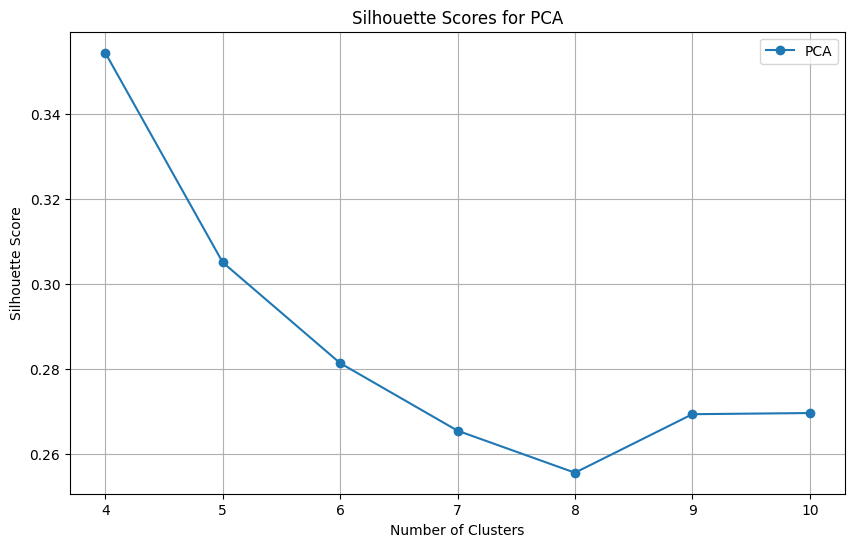

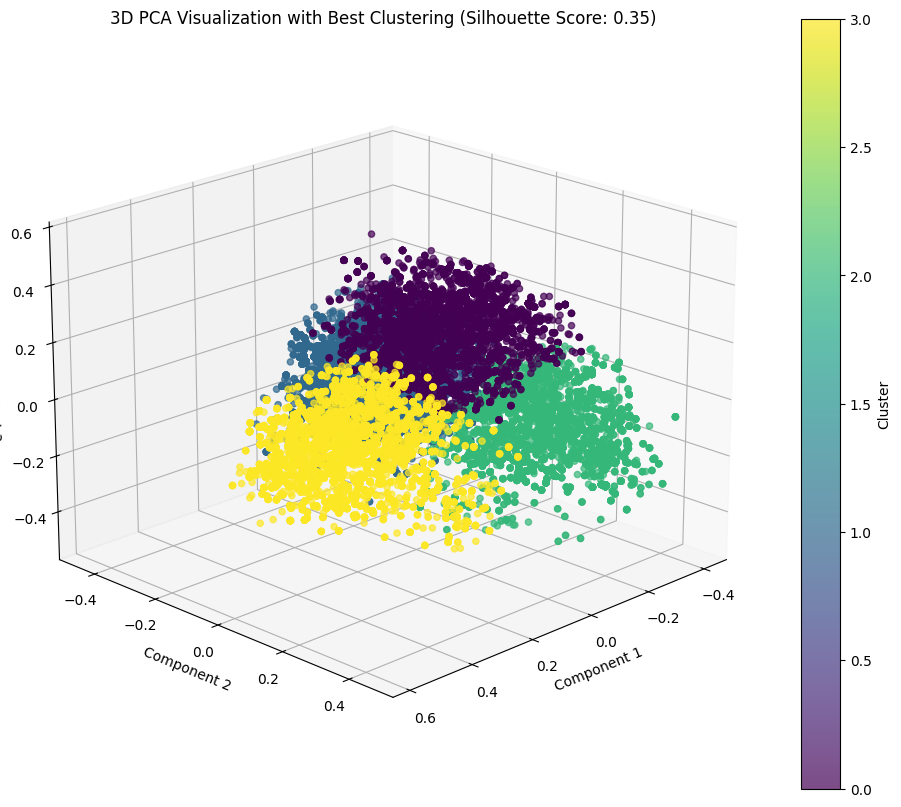

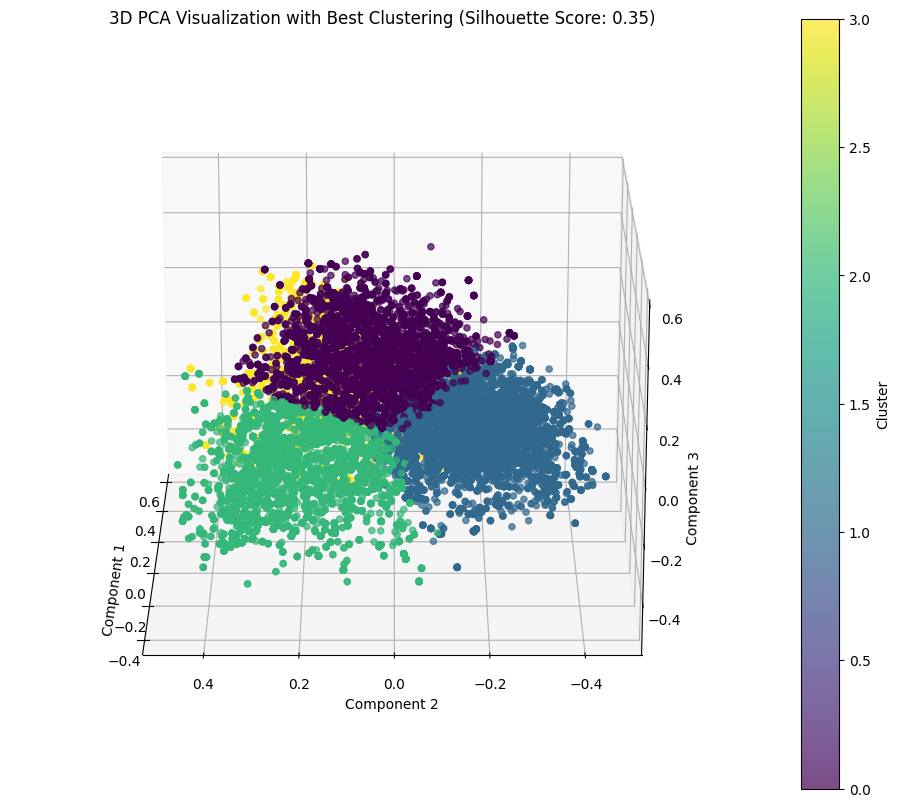

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Load and clean column
big_df['cleaned_industries'] = big_df['industry'].fillna('') + ' ' + big_df['organization_description'].fillna('')

# Generate embeddings for 'Organization Industries' using Sentence-BERT
model = SentenceTransformer('all-MiniLM-L6-v2')
industries_embeddings = model.encode(big_df['cleaned_industries'].tolist(), convert_to_tensor=True)

# Convert embeddings to numpy
embeddings_np = industries_embeddings.cpu().numpy()

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings_np)

# Variables to store results for clustering
results = []

# Try KMeans with different numbers of clusters and store the results
for n_clusters in range(4, 11):  # Try from 4 to 10 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(reduced_embeddings)

    # Evaluate clustering with silhouette score
    sil_score = silhouette_score(reduced_embeddings, kmeans_labels)

    # Store the result for plotting
    results.append({
        "n_clusters": n_clusters,
        "silhouette_score": sil_score,
        "reduced_embeddings": reduced_embeddings,
        "kmeans_labels": kmeans_labels
    })

# Extract the best result based on silhouette score
best_result = max(results, key=lambda x: x['silhouette_score'])

# Assign the best clustering labels to the DataFrame
big_df['company_cluster'] = best_result['kmeans_labels']

# Extract top keywords for each cluster using CountVectorizer and LDA for cluster naming
n_clusters = best_result['n_clusters']
count_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
count_matrix = count_vectorizer.fit_transform(big_df['cleaned_industries'])

# Create a dictionary to store cluster labels (names)
cluster_labels = {}

for cluster_id in range(n_clusters):
    # Filter companies in the current cluster
    cluster_data = big_df[big_df['company_cluster'] == cluster_id]['cleaned_industries']
    if cluster_data.empty:
        continue  # Skip if the cluster has no data
    cluster_matrix = count_vectorizer.transform(cluster_data)

    # Apply LDA for topic extraction
    lda = LDA(n_components=2, random_state=42)
    lda.fit(cluster_matrix)

    # Get top keywords for labeling
    words = count_vectorizer.get_feature_names_out()
    topic_weights = lda.components_[0]
    top_keyword_indices = topic_weights.argsort()[-5:][::-1]
    topic_keywords = [words[i] for i in top_keyword_indices]
    label = ' '.join(topic_keywords)

    # Assign the label to the cluster
    cluster_labels[cluster_id] = label
    big_df.loc[big_df['company_cluster'] == cluster_id, 'industry_label'] = label
    print(f"Cluster {cluster_id} Label: {label}")

# Create the DataFrame
cluster_df = pd.DataFrame.from_dict(cluster_labels, orient='index', columns=['industry_label']).reset_index()

# Rename the 'index' column to 'company_cluster'
cluster_df.rename(columns={'index': 'company_cluster'}, inplace=True)

# Increment 'company_cluster' values by 1
#cluster_df['company_cluster'] = cluster_df['company_cluster'] + 1

# Merge with big_df to ensure company_cluster and organization_id are linked
merged_df = big_df[['organization_id', 'company_cluster']].merge(cluster_df, on='company_cluster', how='left')

# Plot silhouette scores for PCA
plt.figure(figsize=(10, 6))
cluster_counts = [res['n_clusters'] for res in results]
silhouette_scores = [res['silhouette_score'] for res in results]

plt.plot(cluster_counts, silhouette_scores, marker='o', label="PCA")

plt.title('Silhouette Scores for PCA')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot the best model's clustering results
# Plot the best model's clustering results in 3D with a rotated view
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

best_reduced_embeddings = best_result['reduced_embeddings']
best_kmeans_labels = best_result['kmeans_labels']

scatter = ax.scatter(
    best_reduced_embeddings[:, 0], 
    best_reduced_embeddings[:, 1], 
    best_reduced_embeddings[:, 2], 
    c=best_kmeans_labels, 
    cmap='viridis', 
    alpha=0.7
)

# Rotate the plot for a better view
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuth

# Add axis labels and a color bar
ax.set_title(f'3D PCA Visualization with Best Clustering (Silhouette Score: {best_result["silhouette_score"]:.2f})')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.colorbar(scatter, ax=ax, label='Cluster')

plt.show()

# Plot the best model's clustering results in 3D with a rotated view
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

best_reduced_embeddings = best_result['reduced_embeddings']
best_kmeans_labels = best_result['kmeans_labels']

scatter = ax.scatter(
    best_reduced_embeddings[:, 0], 
    best_reduced_embeddings[:, 1], 
    best_reduced_embeddings[:, 2], 
    c=best_kmeans_labels, 
    cmap='viridis', 
    alpha=0.7
)

# Rotate the plot for a better view
ax.view_init(elev=20, azim=180)  # Adjust elevation and azimuth

# Add axis labels and a color bar
ax.set_title(f'3D PCA Visualization with Best Clustering (Silhouette Score: {best_result["silhouette_score"]:.2f})')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.colorbar(scatter, ax=ax, label='Cluster')

plt.show()

# Assign the best clustering labels to the DataFrame
big_df['company_cluster'] = best_kmeans_labels


## Update data frame with new columns and push into Database

In [47]:
def populate_dimension_industry_cluster_from_df(cluster_df, cluster_model, session):
    """
    Populate the DimensionIndustryCluster table from a DataFrame.

    Parameters:
    - cluster_df (pd.DataFrame): DataFrame containing cluster numbers and labels.
    - cluster_model (SQLAlchemy Model): SQLAlchemy model for DimensionIndustryCluster.
    - session (Session): Active SQLAlchemy session.
    """
    try:
        for _, row in cluster_df.iterrows():
            # Check if the cluster already exists in the table
            cluster_record = session.query(cluster_model).filter_by(industry_cluster=row['industry_label']).first()
            if not cluster_record:
                # Insert the new cluster
                cluster_record = cluster_model(industry_cluster=row['industry_label'])
                session.add(cluster_record)
        
        # Commit the changes
        session.commit()
        print("DimensionIndustryCluster table populated successfully.")

    except Exception as e:
        session.rollback()  # Rollback if there is an issue
        print(f"Error while populating DimensionIndustryCluster: {e}")


In [63]:
from sqlalchemy.orm import Session
from tqdm import tqdm
from math import isnan

def push_new_columns_to_db(df, funding_model, org_model, session: Session, funding_id_col='transaction_id', org_id_col='organization_id'):
    def safe_value(value):
        """Convert NaN to None, otherwise return the value."""
        return None if value is None or (isinstance(value, float) and isnan(value)) else value

    try:
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Updating database"):
            with session.no_autoflush:
                # Update FactFunding table
                funding_record = session.query(funding_model).filter(
                    getattr(funding_model, funding_id_col) == row[funding_id_col]
                ).first()
                if funding_record:
                    funding_record.funding_amount_cluster = safe_value(row['funding_amount_cluster'])
                    funding_record.money_raised_cluster = safe_value(row['money_raised_cluster'])
                    funding_record.transaction_cluster = safe_value(row['transaction_cluster'])
                    session.add(funding_record)

                # Update DimensionOrganization table
                org_record = session.query(org_model).filter(
                    getattr(org_model, org_id_col) == row[org_id_col]
                ).first()
                if org_record:
                    org_record.industry_cluster_id = safe_value(row['company_cluster'])
                    session.add(org_record)

        session.commit()
        print("Database updated successfully.")
    except Exception as e:
        session.rollback()
        print(f"Error while updating the database: {e}")


In [49]:
# Increment company_cluster IDs by 1 in both DataFrames
big_df['company_cluster'] += 1
cluster_df['company_cluster'] += 1

# make final adjustment of big dataframe
big_df['transaction_cluster'] = big_df['transaction_cluster_y']
big_df = big_df.drop('transaction_cluster_x',axis=1)
big_df = big_df.drop('transaction_cluster_y',axis=1)

big_df['funding_amount_cluster'] = big_df['funding_amount_cluster_y']
big_df = big_df.drop('funding_amount_cluster_x',axis=1)
big_df = big_df.drop('funding_amount_cluster_y',axis=1)

big_df['money_raised_cluster'] = big_df['money_raised_cluster_y']
big_df = big_df.drop('money_raised_cluster_x',axis=1)
big_df = big_df.drop('money_raised_cluster_y',axis=1)

#convert nan to null 
big_df = big_df.where(big_df.notna(), None)

In [64]:
with session_scope() as session:
    push_new_columns_to_db(big_df, FactFunding, DimensionOrganization, session, funding_id_col='transaction_id', org_id_col='organization_id')
    populate_dimension_industry_cluster_from_df(cluster_df, DimensionIndustryCluster, session)

Updating database: 100%|██████████| 24317/24317 [38:18<00:00, 10.58it/s] 


Database updated successfully.
DimensionIndustryCluster table populated successfully.
